In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda

In [2]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jessicali9530/lfw-dataset

 99% 111M/112M [00:05<00:00, 23.3MB/s]
100% 112M/112M [00:05<00:00, 19.8MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile("/content/lfw-dataset.zip", 'r')
zip_ref.extractall("/content/lfw-dataset")
zip_ref.close()

In [7]:
matchpairs= pd.read_csv("/content/lfw-dataset/matchpairsDevTest.csv")
mismatchpairs= pd.read_csv("/content/lfw-dataset/mismatchpairsDevTest.csv")

In [8]:
matchpairs.head(5)

name  imagenum1  imagenum2
0      Abdullah_Gul         13         14
1      Abdullah_Gul         13         16
2  Abdullatif_Sener          1          2
3    Adel_Al-Jubeir          1          3
4         Al_Pacino          1          2

In [9]:
mismatchpairs.head(5)

name  imagenum1                        name.1  imagenum2
0                AJ_Lamas          1                   Zach_Safrin          1
1             Aaron_Guiel          1             Reese_Witherspoon          3
2            Aaron_Tippin          1  Jose_Luis_Rodriguez_Zapatero          1
3  Abdul_Majeed_Shobokshi          1                  Charles_Cope          1
4            Abdullah_Gul         16                     Steve_Cox          1

In [10]:
def read_image(name, image_num):
    # Temel dosya yolunu belirtiyoruz
    base_path = "/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"

    # 'os.path.join' kullanarak dosya yolu oluşturuyoruz
    file_path = os.path.join(base_path, name, f"{name}_{str(image_num).zfill(4)}.jpg")

    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak oku

    if image is None:  # Eğer resim okunamazsa bir hata mesajı döndürelim
        raise ValueError(f"Resim {file_path} okunamadı.")

    image = image / 255.0  # Normalleştirme
    return image

In [11]:
def prepare_data(matchpairs, mismatchpairs):
    X1 = []
    X2 = []
    Y = []

    # matchpairs veriseti için resimleri okuyun
    for index, row in matchpairs.iterrows():
        image1 = read_image(row['name'], row['imagenum1'])
        image2 = read_image(row['name'], row['imagenum2'])
        X1.append(image1)
        X2.append(image2)
        Y.append(1)  # Aynı kişi olduğu için etiket: 1

    # mismatchpairs veriseti için resimleri okuyun
    for index, row in mismatchpairs.iterrows():
        image1 = read_image(row['name'], row['imagenum1'])
        image2 = read_image(row['name.1'], row['imagenum2'])
        X1.append(image1)
        X2.append(image2)
        Y.append(0)  # Farklı kişiler olduğu için etiket: 0

    return np.array(X1), np.array(X2), np.array(Y)

In [12]:
X1_train, X2_train, Y_train = prepare_data(matchpairs, mismatchpairs)

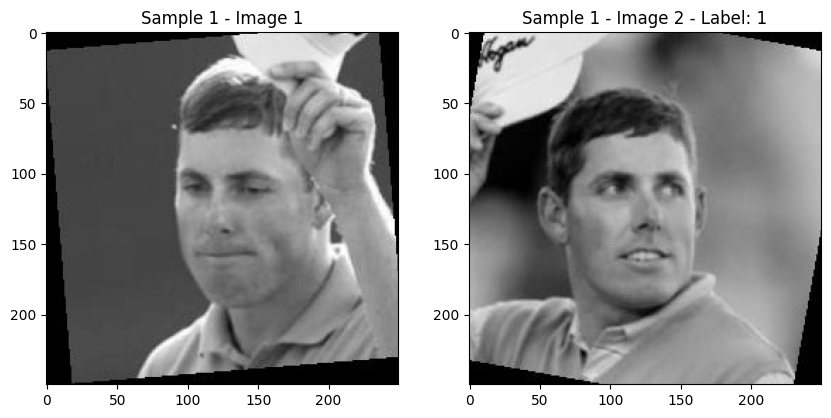

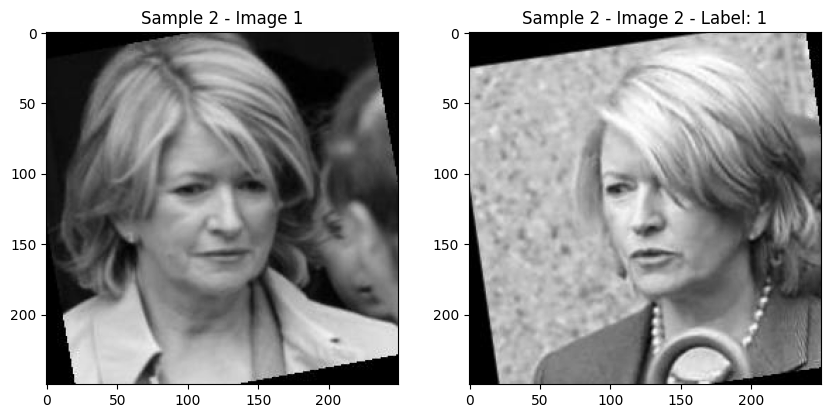

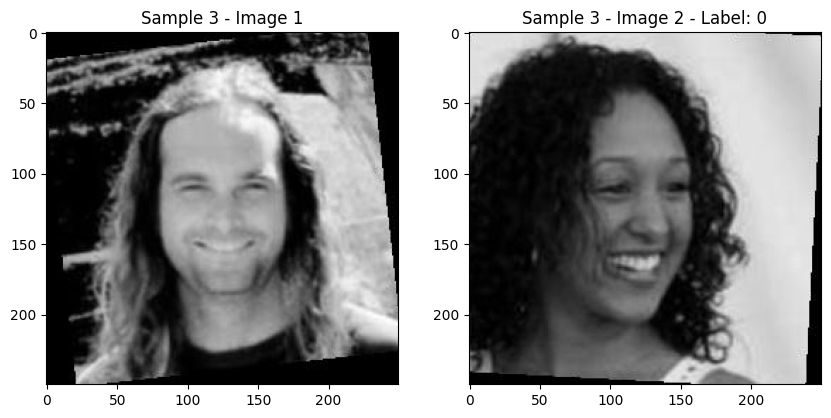

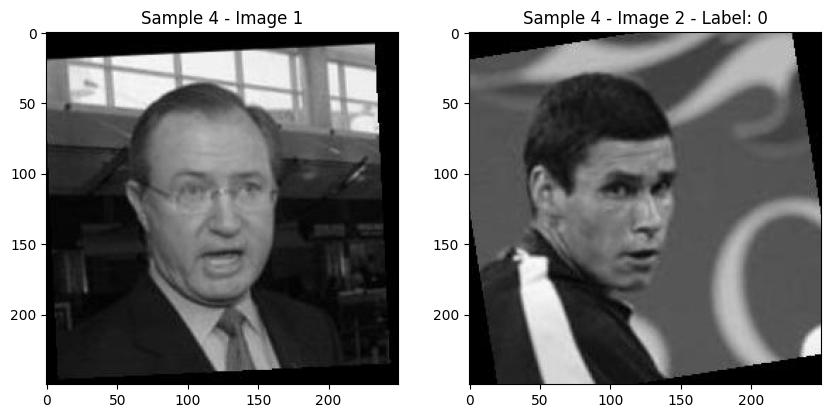

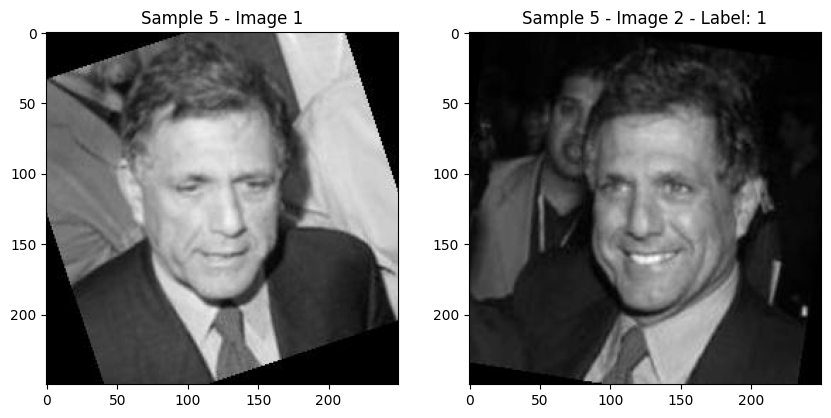

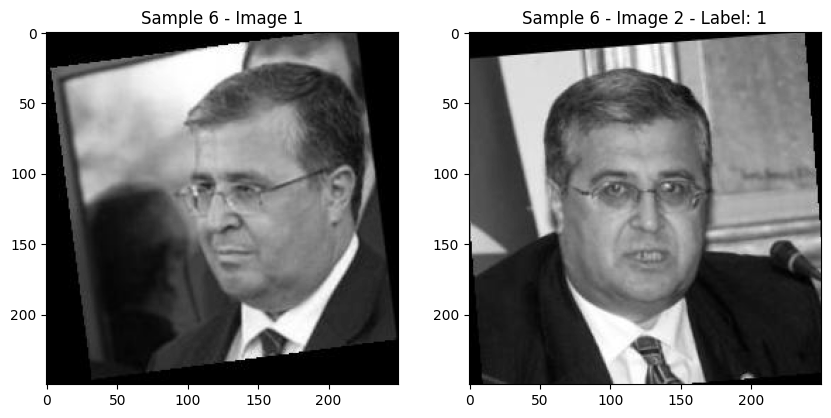

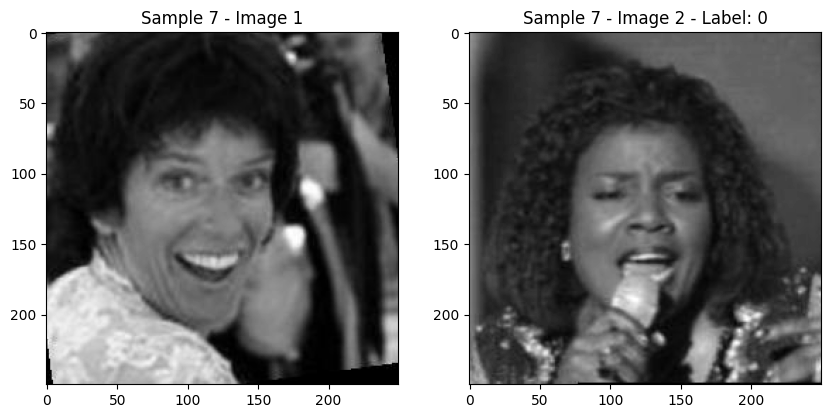

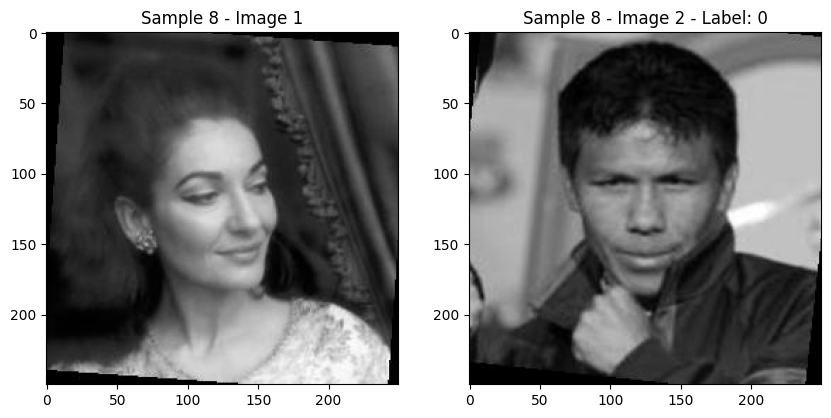

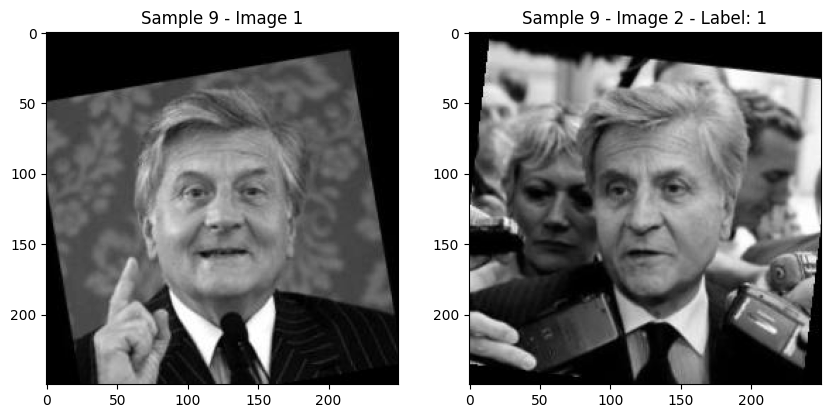

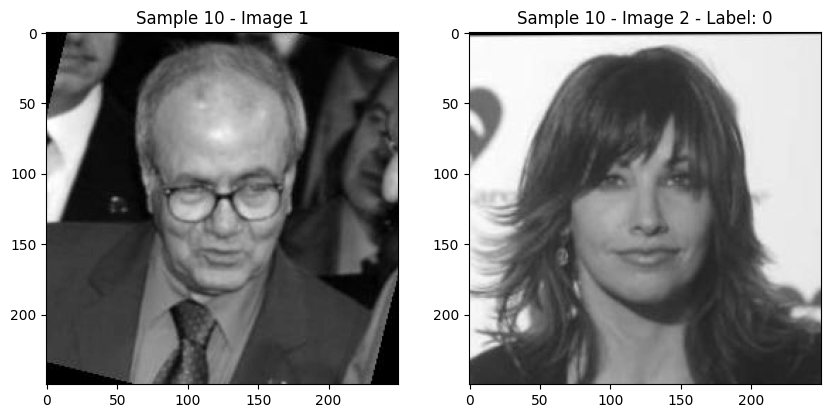

In [ ]:
def visualize_samples(x_train_1, x_train_2, y_train, samples=10):
    indices = np.random.choice(len(x_train_1), samples)

    for i, idx in enumerate(indices):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(x_train_1[idx].squeeze(), cmap='gray')
        plt.title(f'Sample {i + 1} - Image 1')

        plt.subplot(1, 2, 2)
        plt.imshow(x_train_2[idx].squeeze(), cmap='gray')
        plt.title(f'Sample {i + 1} - Image 2 - Label: {y_train[idx]}')

        plt.show()

# Örnekleri görselleştirelim.
visualize_samples(X1_train, X2_train, Y_train)

In [13]:
matchpairs_test = pd.read_csv("/content/lfw-dataset/matchpairsDevTest.csv")
mismatchpairs_test= pd.read_csv("/content/lfw-dataset/mismatchpairsDevTest.csv")

In [14]:
X1_test, X2_test, Y_test = prepare_data(matchpairs_test, mismatchpairs_test)

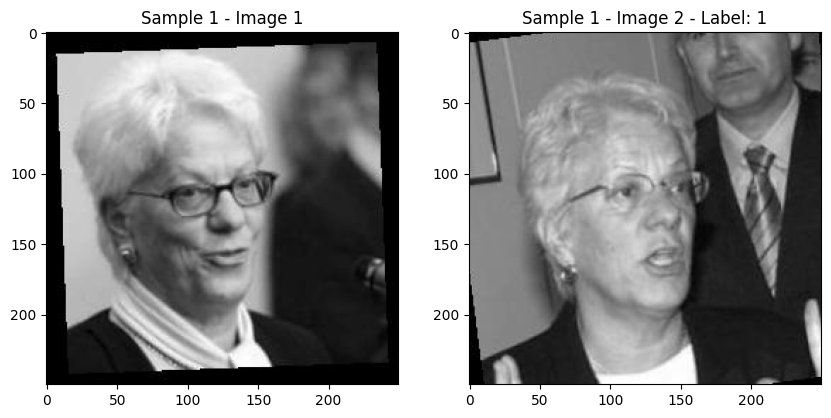

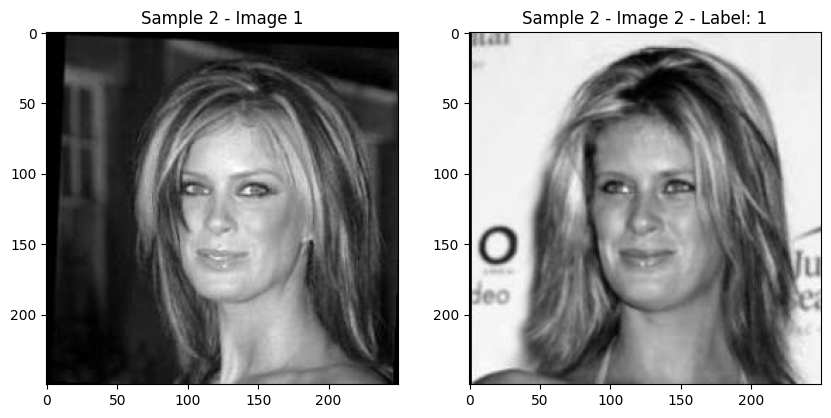

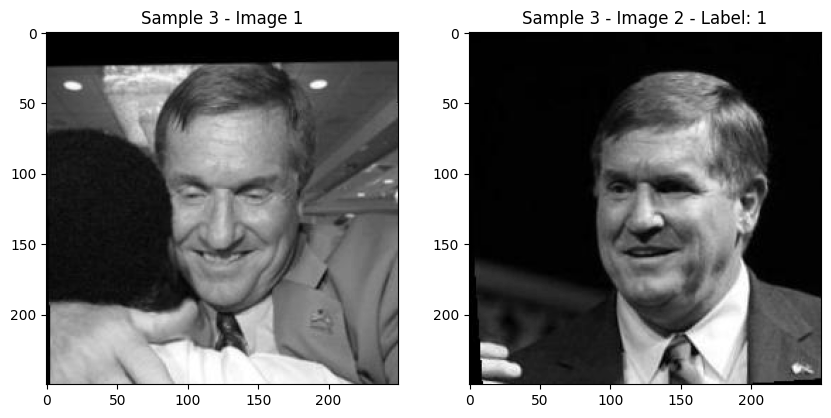

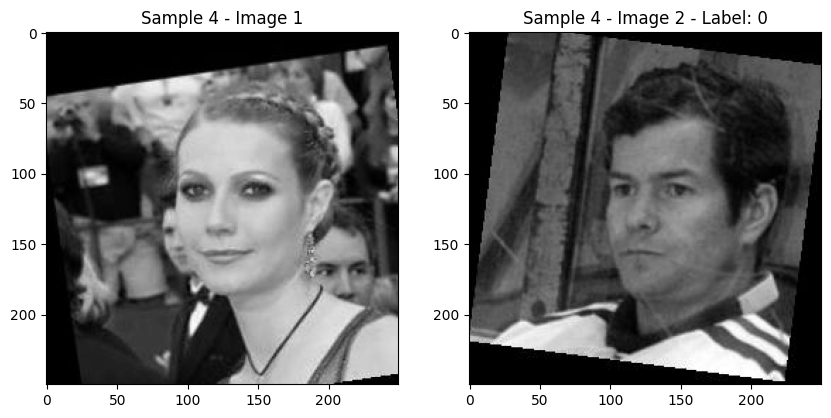

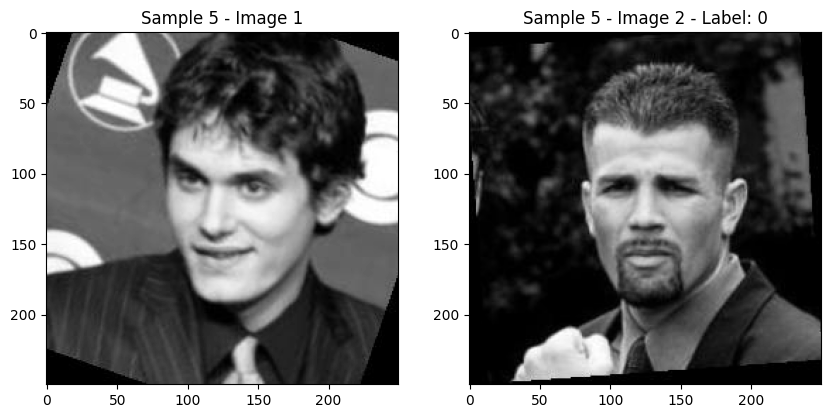

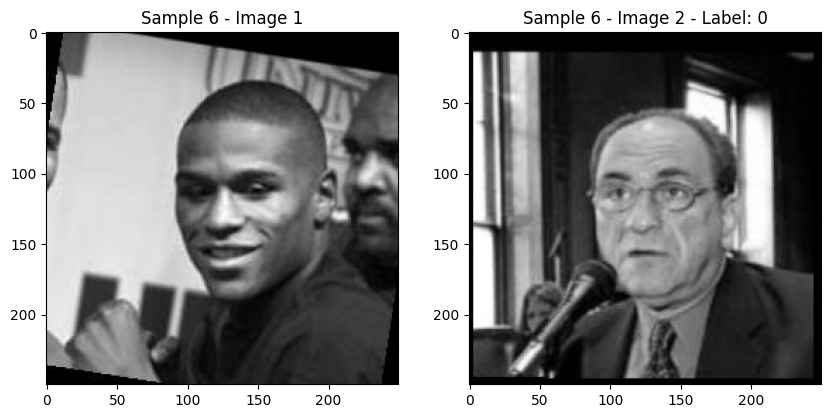

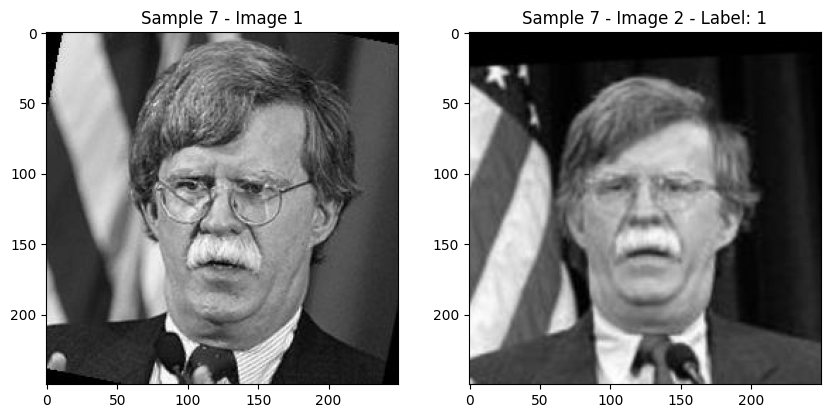

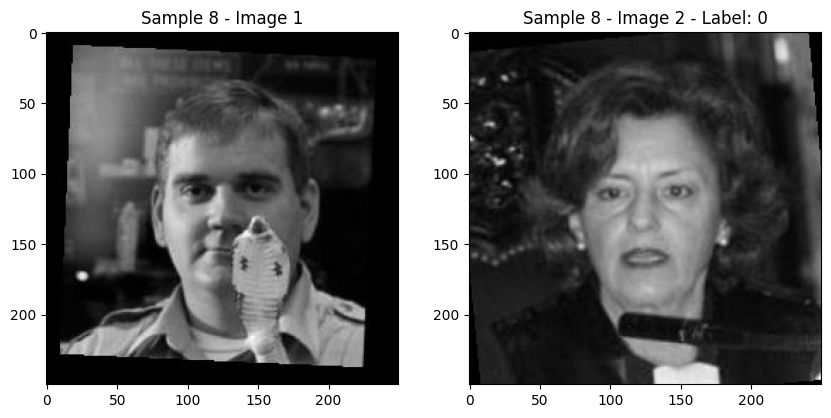

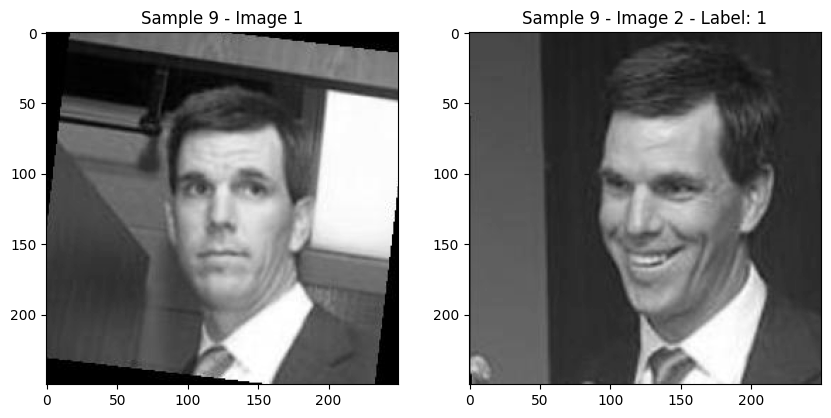

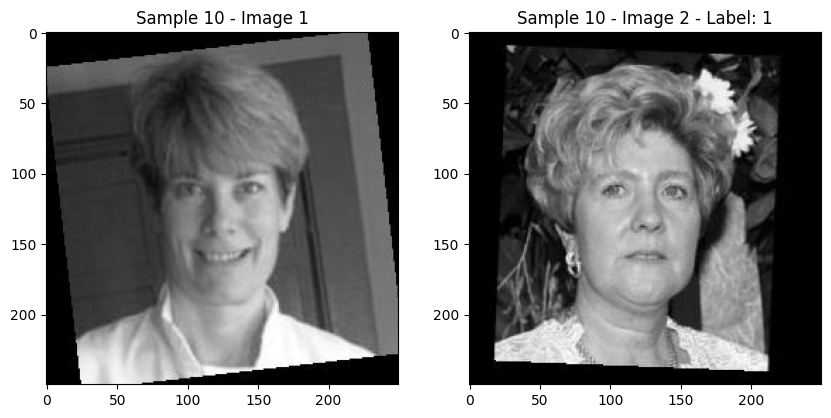

In [ ]:
visualize_samples(X1_test, X2_test, Y_test)

In [15]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = tf.cast(y_true, tf.float32)  # y_true'yi float32'ye dönüştür
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [16]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

# Öklidyen mesafe çıkış şekli
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [17]:
# Calculate accuracy
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.3, y_true.dtype)))

# Calculate the train and test data
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.3
    return np.mean(pred == y_true)

In [ ]:
# Define the first model
base_model = tf.keras.Sequential()

base_model.add(Conv2D(64, (10, 10), activation='relu', input_shape=(250, 250, 1)))
base_model.add(MaxPooling2D(3, strides=2))
base_model.add(Dropout(0.25))

base_model.add(Conv2D(128, (7, 7), activation='relu', padding='same'))
base_model.add(MaxPooling2D(3, strides=2))
base_model.add(Dropout(0.25))

base_model.add(Conv2D(256, (4, 4), activation='relu', padding='same'))
base_model.add(MaxPooling2D(3, strides=2))
base_model.add(Dropout(0.25))

base_model.add(Flatten())
base_model.add(Dense(512, activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(Dense(128, activation='relu'))

# define the inputs
input1 = Input(shape=(250, 250, 1))
input2 = Input(shape=(250, 250, 1))

output1 = base_model(input1)
output2 = base_model(input2)


distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([output1, output2])
siamese_model = Model([input1, input2], distance)

# Compile the model
siamese_model.compile(optimizer='adam', loss=contrastive_loss, metrics=[accuracy])
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 250, 250, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  1112302   ['input_1[0][0]',             
                                                          72         'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

In [ ]:
history = siamese_model.fit([X1_train,X2_train], Y_train, epochs=40, batch_size=64, validation_split=0.2)

Epoch 1/40
13/13 [==============================] - 23s 475ms/step - loss: 2.5631 - accuracy: 0.4952 - val_loss: 0.8948 - val_accuracy: 0.0000e+00
Epoch 2/40
13/13 [==============================] - 3s 234ms/step - loss: 0.2547 - accuracy: 0.4579 - val_loss: 0.9412 - val_accuracy: 0.0000e+00
Epoch 3/40
13/13 [==============================] - 3s 234ms/step - loss: 0.2403 - accuracy: 0.4555 - val_loss: 0.9332 - val_accuracy: 0.0000e+00
Epoch 4/40
13/13 [==============================] - 3s 234ms/step - loss: 0.2447 - accuracy: 0.4663 - val_loss: 0.9636 - val_accuracy: 0.0000e+00
Epoch 5/40
13/13 [==============================] - 3s 233ms/step - loss: 0.2489 - accuracy: 0.5132 - val_loss: 0.9594 - val_accuracy: 0.0000e+00
Epoch 6/40
13/13 [==============================] - 3s 234ms/step - loss: 0.2408 - accuracy: 0.4447 - val_loss: 0.9404 - val_accuracy: 0.0000e+00
Epoch 7/40
13/13 [==============================] - 3s 234ms/step - loss: 0.2406 - accuracy: 0.4339 - val_loss: 0.9524 - va

In [ ]:
# Test doğruluk hesaplama
preds = siamese_model.predict([X1_test, X2_test])
acc = compute_accuracy(Y_test, preds)
print("Test accuracy : ", acc)

32/32 [==============================] - 1s 31ms/step
Test accuracy :  0.821


In [18]:
# Define the second model
base_model2 = tf.keras.Sequential()

base_model2.add(Conv2D(64, (10, 10), activation='relu', input_shape=(250, 250, 1)))
base_model2.add(MaxPooling2D(3, strides=2))
base_model2.add(Dropout(0.25))

base_model2.add(Conv2D(128, (7, 7), activation='relu', padding='same'))
base_model2.add(MaxPooling2D(3, strides=2))
base_model2.add(Dropout(0.25))

base_model2.add(Conv2D(256, (4, 4), activation='relu', padding='same'))
base_model2.add(MaxPooling2D(3, strides=2))
base_model2.add(Dropout(0.25))

base_model2.add(Dense(512, activation='relu'))
base_model2.add(Flatten())

base_model2.add(Dense(1024, activation='sigmoid'))


input1 = Input(shape=(250, 250, 1))
input2 = Input(shape=(250, 250, 1))

output1 = base_model2(input1)
output2 = base_model2(input2)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([output1, output2])
siamese_model2 = Model([input1, input2], distance)


siamese_model2.compile(optimizer='adam', loss=contrastive_loss, metrics=[accuracy])
siamese_model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 250, 250, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 1024)                 4419913   ['input_1[0][0]',             
                                                          60         'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

In [19]:
# Train the data
history2 = siamese_model2.fit([X1_train,X2_train], Y_train, epochs=40, batch_size=64, validation_split=0.2)

Epoch 1/40
13/13 [==============================] - 77s 2s/step - loss: 0.4302 - accuracy: 0.5361 - val_loss: 0.6700 - val_accuracy: 0.0742
Epoch 2/40
13/13 [==============================] - 2s 150ms/step - loss: 0.2239 - accuracy: 0.5781 - val_loss: 0.5231 - val_accuracy: 0.3477
Epoch 3/40
13/13 [==============================] - 2s 150ms/step - loss: 0.2169 - accuracy: 0.5397 - val_loss: 0.7265 - val_accuracy: 0.0352
Epoch 4/40
13/13 [==============================] - 2s 149ms/step - loss: 0.2128 - accuracy: 0.5805 - val_loss: 0.6865 - val_accuracy: 0.0508
Epoch 5/40
13/13 [==============================] - 2s 150ms/step - loss: 0.2102 - accuracy: 0.5913 - val_loss: 0.4860 - val_accuracy: 0.4609
Epoch 6/40
13/13 [==============================] - 2s 150ms/step - loss: 0.2050 - accuracy: 0.5938 - val_loss: 0.5451 - val_accuracy: 0.3281
Epoch 7/40
13/13 [==============================] - 2s 149ms/step - loss: 0.1812 - accuracy: 0.5697 - val_loss: 0.6106 - val_accuracy: 0.1328
Epoch 8/

In [23]:
# Evaluate the model
preds = siamese_model2.predict([X1_test, X2_test])
acc = compute_accuracy(Y_test, preds)
print("Test accuracy : ", acc)

32/32 [==============================] - 1s 22ms/step
Test accuracy :  0.973


## **Explanation and Conclusions**
**This work addressed the task of face verification using a Siamese network. Our dataset was realized on the Labeled Faces in the Wild (LFW) dataset and was used for our model to learn similarities between faces. The main goal of the work was to perform face verification by comparing the faces of different people in the dataset.**

**The Siamese network used in the project takes two input images and learns the degree of similarity between them. During training, using data in pairs, our model was trained to learn low similarity between faces of the same person and high similarity between faces of different people. In this way, the model learned a unique representation for identifying similarities between faces.**

**The results were quite successful. The success rate on the test dataset was 97.3%. This high accuracy rate shows that the Siamese network is effective in the face verification task. Face verification applications can be used in many areas ranging from security systems to personal recognition and automatic labeling applications.**

**This study provides an example of how Siamese networks can be used for face verification. In the future, it may be possible to further improve this approach using larger datasets and more complex models.**

##**(TR) Açıklama ve Sonuçlar**
**Bu çalışma, Siamese ağı kullanarak yüz doğrulama görevini ele aldı. Veri kümemiz, Labeled Faces in the Wild (LFW) veri kümesi üzerinde gerçekleştirildi ve modelimizin yüzler arasındaki benzerlikleri öğrenmesi için kullanıldı. Çalışmanın temel amacı, veri kümesindeki farklı kişilerin yüzlerini karşılaştırarak yüz doğrulama işlemini gerçekleştirmekti.**

**Projede kullanılan Siamese ağı, iki giriş görüntüsünü alır ve bu görüntülerin benzerlik derecesini öğrenir. Eğitim sırasında, çiftler halinde veriler kullanılarak modelimiz, aynı kişiye ait yüzler arasında düşük benzerlik ve farklı kişilere ait yüzler arasında yüksek benzerlik öğrenmek üzere eğitildi. Bu sayede model, yüzler arasındaki benzerlikleri belirleyebilmek için özgün bir temsil öğrendi.**

**Elde edilen sonuçlar oldukça başarılıydı. Test veri kümesi üzerindeki başarı oranı %97.3 olarak ölçüldü. Bu yüksek doğruluk oranı, Siamese ağının yüz doğrulama görevinde etkili olduğunu göstermektedir. Yüz doğrulama uygulamaları, güvenlik sistemlerinden kişisel tanıma ve otomatik etiketleme uygulamalarına kadar birçok alanda kullanılabilir.**

**Bu çalışma, Siamese ağlarının yüz doğrulama görevinde nasıl kullanılabileceğini gösteren bir örnek sunmaktadır. Gelecekte, daha büyük veri kümeleri ve daha karmaşık modeller kullanarak bu yaklaşımın daha da iyileştirilmesi mümkün olabilir.**